# **CSC8637 Coursework Task 2**

Starting by importing the libraries that I am going to use for this notebook and setting up the google drive access and the path for the dataset.

## **Import Libraries and Setup**

In [12]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the dataset
dataset_path = '/content/drive/My Drive/Colab/fgvc-aircraft-2013b'

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Set seeds**

The below function initializes random number generators in Python, NumPy, and PyTorch to ensure consistent and reproducible results across runs. It also sets PyTorch's CUDA behavior for deterministic operations, essential in machine learning for replicable outcomes.

In [13]:
def set_seeds(seed_value=42):
    """Set seeds for reproducibility."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # Numpy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seeds()

## **Dataset Class and Transformations**


This custom class AircraftDataset extends PyTorch's Dataset class, enabling it to handle loading and preprocessing of aircraft images and labels from a CSV file. It includes functionality to read image paths and labels, apply specified transformations, and crop the bottom 20 pixels of each image, a unique requirement of this dataset.

In [14]:
class AircraftDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_name)
        # Crop the bottom 20 pixels
        image = image.crop((0, 0, image.width, image.height - 20))

        label = int(self.dataframe.iloc[idx]['Labels'])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

## **Load Datasets**


The below code sets up the directories for the dataset and initializes the training, validation, and test datasets using the AircraftDataset class. It defines image preprocessing transformations, including resizing, converting to tensor, and normalizing, to ensure the images are in the correct format for model input.

In [15]:
# Set up the base directory where CSV files are located
data_dir = os.path.join(dataset_path, 'data')
image_dir = os.path.join(data_dir, 'images')

# Now specify the path to the images and CSV files
train_csv = os.path.join(dataset_path, 'train.csv')
val_csv = os.path.join(dataset_path, 'val.csv')
test_csv = os.path.join(dataset_path, 'test.csv')

# Define the transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the dataset for training, validation, and testing
train_dataset = AircraftDataset(csv_file=train_csv, root_dir=image_dir, transform=transform)
val_dataset = AircraftDataset(csv_file=val_csv, root_dir=image_dir, transform=transform)
test_dataset = AircraftDataset(csv_file=test_csv, root_dir=image_dir, transform=transform)

## **Sample Visualisation**

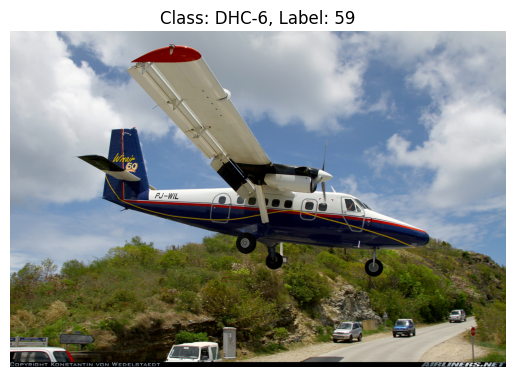

In [16]:
import matplotlib.pyplot as plt

def show_image_sample(dataframe_vis, image_dir_vis):
    # Select a random sample from the dataframe
    sample = dataframe_vis.sample(1).iloc[0]
    img_path = os.path.join(image_dir_vis, sample['filename'])
    label = sample['Labels']
    class_name = sample['Classes']

    # Load and display the image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f"Class: {class_name}, Label: {label}")
    plt.axis('off')
    plt.show()

# Example usage
csv_file = '/content/drive/MyDrive/Colab/fgvc-aircraft-2013b/train.csv'
image_dir_vis = '/content/drive/MyDrive/Colab/fgvc-aircraft-2013b/data/images'
dataframe_vis = pd.read_csv(csv_file)
show_image_sample(dataframe_vis, image_dir_vis)

## **DataLoader Setup**

The below functions establish DataLoader instances for training, validation, and testing. The worker_init_fn ensures each worker of the DataLoader has a unique but deterministic seed for reproducibility, while get_data_loader creates DataLoaders with controlled shuffling and parallel data loading, aiding in efficient and consistent data feeding to the model during training and evaluation.

In [ ]:
# Function to initialize workers of DataLoader for reproducibility
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

# Function to create a DataLoader with controlled randomness
def get_data_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)

batch_size = 16

# Create DataLoaders for training, validation, and testing
train_loader = get_data_loader(train_dataset, batch_size)
val_loader = get_data_loader(val_dataset, batch_size)
test_loader = get_data_loader(test_dataset, batch_size)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Model Definition**

This code initializes a ResNet50 model with the latest default pre-trained weights for enhanced feature extraction. The final fully connected layer is customized to output 100 classes, matching the specific requirements of my dataset.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Load the ResNet50 model with pretrained weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


## **Loss Function and Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## **Training and Validation Functions**

These functions define the core training and validation procedures for each epoch. train_one_epoch actively trains the model by iterating over the training dataset, computing the loss, and updating the model weights. validate, on the other hand, evaluates the model on the validation dataset without updating its weights, providing an estimation of the model's performance on unseen data. Both functions calculate and return the average loss over the respective datasets.

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(val_loader.dataset)

## **Hyperparameter Tuning and Training Loop**

The below block of code implements a hyperparameter tuning process for my model. It iterates through 2 different batch sizes values, training and validating the model for each combination. Early stopping is employed to halt training if the validation loss does not improve for a specified number of epochs, optimizing computational efficiency. The best performing model configuration, as determined by the lowest validation loss, is saved, and its hyperparameters are reported. Based on experimental observations, it was determined that a learning rate of 0.0001, coupled with the Adam optimizer, consistently yielded the most favorable results. Consequently, the decision was made to exclusively utilize these parameters for further model training and optimization.

In [ ]:
# Define Hyperparameters to Tune
num_epochs = 50
learning_rates = [0.0001]
batch_sizes = [16, 32]
optimizers = {'Adam': optim.Adam}

# Early Stopping Parameters
early_stopping_patience = 15
early_stopping_delta = 0.01

# Initialize variables for tracking the best model
best_val_loss = float('inf')
best_hyperparams = {'learning_rate': None, 'batch_size': None, 'optimizer': None}
best_model_state = None

# Hyperparameter Tuning Loop
for lr in learning_rates:
    for bs in batch_sizes:
        # Setup DataLoaders for the current batch size
        train_loader = get_data_loader(train_dataset, bs)
        val_loader = get_data_loader(val_dataset, bs)

        for opt_name, opt_func in optimizers.items():
            print(f"Training with lr: {lr}, batch size: {bs}, optimizer: {opt_name}")

            # Model Setup
            model = models.resnet50(weights=weights)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 100)
            model = model.to(device)

            # Loss function and Optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = opt_func(model.parameters(), lr=lr)

            # Reset early stopping counter for each hyperparameter combination
            early_stopping_counter = 0

            # Training and Validation for the current set of hyperparameters
            for epoch in range(num_epochs):
                train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
                val_loss = validate(model, val_loader, criterion, device)
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

                # Early Stopping Check
                if val_loss < best_val_loss - early_stopping_delta:
                    best_val_loss = val_loss
                    best_hyperparams = {'learning_rate': lr, 'batch_size': bs, 'optimizer': opt_name}
                    best_model_state = model.state_dict()
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_patience:
                        print("Stopping early due to lack of improvement in validation loss.")
                        break

# Save the best model's state dict
torch.save(best_model_state, 'best_model.pth')

# Print Best Hyperparameters
print(f"Best Hyperparameters: {best_hyperparams}")


Training with lr: 0.0001, batch size: 16, optimizer: Adam
Epoch 1/50, Train Loss: 4.1644, Validation Loss: 2.9607
Epoch 2/50, Train Loss: 2.2189, Validation Loss: 1.6978
Epoch 3/50, Train Loss: 1.1726, Validation Loss: 1.2962
Epoch 4/50, Train Loss: 0.6154, Validation Loss: 1.0808
Epoch 5/50, Train Loss: 0.3422, Validation Loss: 0.9635
Epoch 6/50, Train Loss: 0.1768, Validation Loss: 0.8665
Epoch 7/50, Train Loss: 0.1032, Validation Loss: 0.8724
Epoch 8/50, Train Loss: 0.0547, Validation Loss: 0.7953
Epoch 9/50, Train Loss: 0.0344, Validation Loss: 0.8383
Epoch 10/50, Train Loss: 0.0362, Validation Loss: 0.8916
Epoch 11/50, Train Loss: 0.0415, Validation Loss: 0.9555
Epoch 12/50, Train Loss: 0.0574, Validation Loss: 1.0374
Epoch 13/50, Train Loss: 0.0402, Validation Loss: 0.9997
Epoch 14/50, Train Loss: 0.0853, Validation Loss: 1.0831
Epoch 15/50, Train Loss: 0.0446, Validation Loss: 0.8283
Epoch 16/50, Train Loss: 0.0116, Validation Loss: 0.8516
Epoch 17/50, Train Loss: 0.0130, Valida

## **Testing and Evaluation**

To ensure the reproducibility of these results, you will need to first set the initial path in the project to reflect the location where your dataset and relevant files are stored. Additionally, it's essential to transfer the trained model file to your Google Colab workspace, specifically to the directory /content. Once these steps are completed, executing the following code block in your Colab notebook should yield identical results as previously obtained.

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', labels=np.unique(all_labels), zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', labels=np.unique(all_labels), zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', labels=np.unique(all_labels), zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, conf_matrix

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader, device)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}')

Accuracy: 0.7572757275727573
Precision: 0.7936224469146497
Recall: 0.757192513368984
F1 Score: 0.7574774062249243
Confusion Matrix:
[[25  1  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 1  0 17 ...  0  0  0]
 ...
 [ 1  0  0 ... 28  0  0]
 [ 0  0  0 ...  0 32  0]
 [ 0  0  0 ...  0  0 32]]



The model has achieved an accuracy of approximately 75.73%. This level of accuracy reflects its effectiveness in correctly identifying the majority of the classes. Precision stands at around 79.36%, suggesting a high degree of reliability in the model's predictions. When the model assigns a class label, it is correct most of the time. The recall rate, at about 75.72%, indicates the model's adeptness in capturing most of the relevant instances across various classes. The F1 Score, sitting at approximately 75.75%, portrays a commendable balance between precision and recall, signifying the model's overall robustness.

The confusion matrix presents a detailed view of the model's performance across different classes. Diagonal elements (high values) indicate correct predictions, while off-diagonal elements (ideally lower values) show misclassifications. The spread across the matrix suggests some confusion between certain classes, but a generally strong performance in distinguishing most of them. This balance of metrics indicates a well-performing model, although there might still be room for improvement, especially in reducing misclassifications, as indicated by the off-diagonal elements in the confusion matrix.

## **Demonstration**

In [ ]:
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision import models
import torch.nn as nn

def demo_classify_and_evaluate(model_path, csv_file, image_dir, transform, device):
    # Load the trained model
    model = models.resnet50(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 100)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Read the CSV file
    demo_data = pd.read_csv(csv_file)
    predictions = []
    true_labels = demo_data['Labels'].tolist()

    # Process and predict each image
    with torch.no_grad():
        for img_filename in demo_data['filename']:
            img_path = os.path.join(image_dir, img_filename)
            image = Image.open(img_path)
            image = image.crop((0, 0, image.width, image.height - 20))  # Crop the bottom 20 pixels
            image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
            image = image.to(device)

            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predictions.append(predicted.item())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, precision, recall, f1, conf_matrix

# Define paths and settings
model_path = '/content/best_model.pth'
csv_file = '/content/drive/MyDrive/Colab/fgvc-aircraft-2013b/test.csv'
image_dir = '/content/drive/MyDrive/Colab/fgvc-aircraft-2013b/data/images'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Run the demo function
accuracy, precision, recall, f1, conf_matrix = demo_classify_and_evaluate(model_path, csv_file, image_dir, transform, device)

# Output results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
